In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
import os
import numpy as np
import pandas as pd
import re
import string
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# from transformers import Adam, get_linear_schedule_with_warmup
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
columns = ['target', 'id', 'date', 'flag', 'user', 'text']

df = pd.read_csv(f"{kazanova_sentiment140_path}/training.1600000.processed.noemoticon.csv",
                 encoding="latin1", header=None)

df.columns = columns

df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)


df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
print(f"Number of missing values in the data:\n{df.isnull().sum()}")

Number of missing values in the data:
target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64


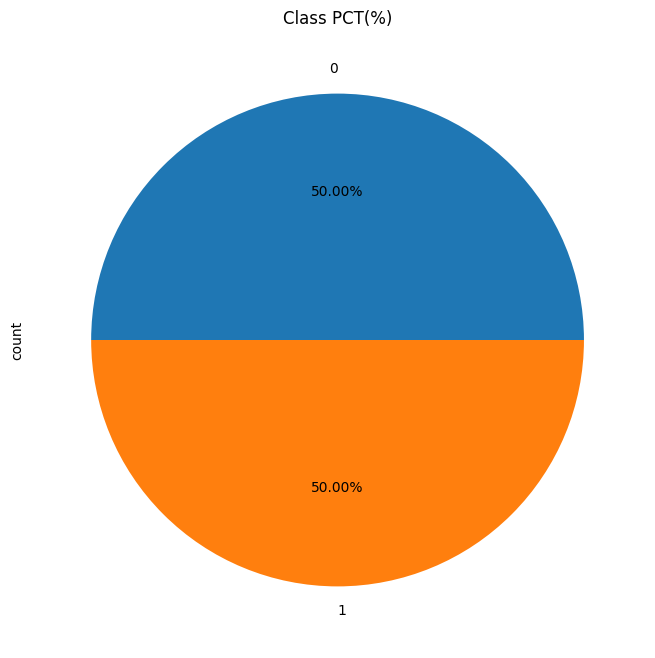

In [8]:
df['target'].value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(8, 8), title = "Class PCT(%)");

### `Data Analysis`

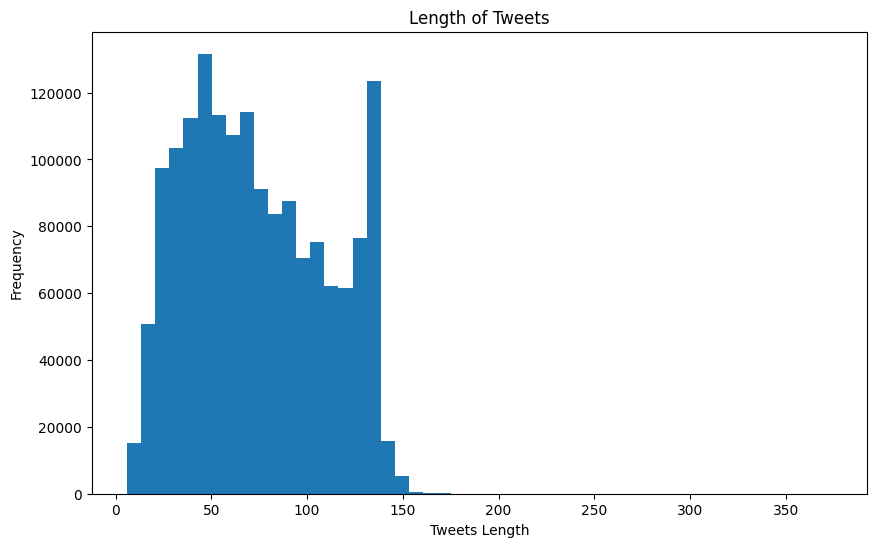

In [9]:
## Check Length of Tweets
length_tweets = df['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
!pip install emoji datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; p

In [11]:
import dask.dataframe as dd
import emoji
# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_tweet(text):
    text = emoji.demojize(text)  # Convert emojis to text (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove Mentions
    text = re.sub(r"#", "", text)  # Remove Hashtags
    text = re.sub(r"[^a-zA-Z\s:]", "", text)  # Remove special characters but keep emoji text
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply function in parallel
df["cleaned_text"] = df["text"].apply(clean_tweet)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [13]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_text"])
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["cleaned_text"])
max_len = 50  # Maximum sequence length
X = pad_sequences(sequences, maxlen=max_len)

# Convert labels to NumPy array
y = np.array(df["target"])  # Make sure your dataset has a 'sentiment' column (0: Negative, 1: Positive)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz -q
!gunzip cc.en.300.vec.gz  -q

--2025-03-30 10:38:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.59, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  88.6MB/s    in 17s     

2025-03-30 10:39:12 (76.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
# Load FastText embeddings
embedding_index = {}
with open("cc.en.300.vec", encoding="utf8") as f:  # Download from FastText website
    next(f)  # Skip first line
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Create embedding matrix
embedding_dim = 300  # FastText uses 300D embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# Define model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),  # First LSTM layer
    Dropout(0.3),
    Bidirectional(LSTM(128)),  # Second LSTM layer
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")  # Binary classification
])

# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     121,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,776,000 (464.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 121,776,000 (464.54 MB)

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split train further into train and validation (80% train, 20% validation from train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


model.fit(X_train, y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_val, y_val))

Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 192s 23ms/step - accuracy: 0.7525 - loss: 0.5023 - val_accuracy: 0.7866 - val_loss: 0.4531
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 207s 24ms/step - accuracy: 0.7876 - loss: 0.4502 - val_accuracy: 0.7948 - val_loss: 0.4377
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 199s 23ms/step - accuracy: 0.7970 - loss: 0.4336 - val_accuracy: 0.7986 - val_loss: 0.4317
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 207s 24ms/step - accuracy: 0.8026 - loss: 0.4233 - val_accuracy: 0.8014 - val_loss: 0.4279
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 201s 24ms/step - accuracy: 0.8084 - loss: 0.4133 - val_accuracy: 0.8030 - val_loss: 0.4246
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 189s 24ms/step - accuracy: 0.8136 - loss: 0.4047 - val_accuracy: 0.8021 - val_loss: 0.4270
Epoch 7/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 203s 24ms/step - accuracy: 0.8189 - loss: 0.3947 - val_accuracy: 0.8018 - val_loss: 0.4278
Epoch 8/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 199s 25ms/step - accuracy: 

In [ ]:
def predict_sentiment(text):
    cleaned = clean_tweet(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    score = model.predict(padded)[0][0]
    return "Positive" if score > 0.5 else "Negative"

# Example
print(predict_sentiment("I love this movie! 😊"))
print(predict_sentiment("This is the worst thing ever..."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Negative
